In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kvasir-seg.zip to kvasir-seg.zip


In [ ]:
import zipfile
import os


zip_file_path = "kvasir-seg.zip"
extract_folder = "Kvasir-SEG"


if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(extract_folder)


    print(os.listdir(extract_folder))
else:
    print(f"file {zip_file_path} not exist")



['Kvasir-SEG']


In [ ]:
import os

base_dir = "Kvasir-SEG/Kvasir-SEG"
images_dir = os.path.join(base_dir, "images")
masks_dir = os.path.join(base_dir, "masks")


if os.path.exists(images_dir) and os.path.exists(masks_dir):
    image_files = os.listdir(images_dir)
    mask_files = os.listdir(masks_dir)

    print(f"Number of images: {len(image_files)}")
    print(f"Number of masks: {len(mask_files)}")
else:
    print(f"Either {images_dir} or {masks_dir} does not exist!")


Number of images: 1000
Number of masks: 1000


In [ ]:
import torch
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


base_dir = "Kvasir-SEG/Kvasir-SEG"
images_dir = os.path.join(base_dir, "images")
masks_dir = os.path.join(base_dir, "masks")

IMG_SIZE = (1024, 1024)
BATCH_SIZE = 16


image_paths = sorted([os.path.join(images_dir, fname) for fname in os.listdir(images_dir)])
mask_paths = sorted([os.path.join(masks_dir, fname) for fname in os.listdir(masks_dir)])


assert len(image_paths) == len(mask_paths), "image not equal to musk！"


train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)


class KvasirDataset(Dataset):
    def __init__(self, images, masks, transform=None, target_transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)


        image = cv2.resize(image, IMG_SIZE)
        mask = cv2.resize(mask, IMG_SIZE)


        image = image / 255.0
        mask = mask / 255.0
        mask = (mask > 0.5).astype(np.float32)


        if self.transform:
            image = self.transform(image).to(torch.float32)
        if self.target_transform:
            mask = self.target_transform(mask).to(torch.float32)

        return image, mask


image_transform = transforms.Compose([
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = KvasirDataset(train_images, train_masks, transform=image_transform, target_transform=mask_transform)
val_dataset = KvasirDataset(val_images, val_masks, transform=image_transform, target_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


for images, masks in train_loader:
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)
    break


Image batch shape: torch.Size([16, 3, 1024, 1024])
Mask batch shape: torch.Size([16, 1, 1024, 1024])


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth




  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ezlvy314
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ezlvy314
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=1ce6df8065adf915ffe7225ecccd744610e96446095e54b3bf35018638458a96
  Stored in directory: /tmp/pip-ephem-wheel-cache-kzve3nt5/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-11-07 10:09:29--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.102, 108.157.254.121, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|

In [ ]:
from segment_anything import sam_model_registry, SamPredictor


sam_model = sam_model_registry["vit_b"](checkpoint="sam_vit_b.pth")
print("SAM model loaded successfully!")


sam_predictor = SamPredictor(sam_model)


sam_predictor.model.to(device="cuda" if torch.cuda.is_available() else "cpu")



/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


SAM model loaded successfully!


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [ ]:
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt



def get_bounding_box(mask):
    """
    从真实掩膜中提取边界框 (x_min, y_min, x_max, y_max)
    """


    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)


    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return x_min, y_min, x_max, y_max



def generate_predictions(image_path, mask_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = (true_mask > 127).astype(np.uint8)


    bounding_box = get_bounding_box(true_mask)
    if bounding_box is None:
        print("Empty mask, skipping...")
        return np.zeros_like(true_mask)

    x_min, y_min, x_max, y_max = bounding_box
    input_box = np.array([[x_min, y_min], [x_max, y_max]])


    sam_predictor.set_image(image)


    masks, _, _ = sam_predictor.predict(box=input_box, multimask_output=False)
    return masks[0]




def evaluate_predictions(pred_mask, true_mask):
    pred_flat = pred_mask.flatten()
    true_flat = true_mask.flatten()
    intersection = np.logical_and(pred_flat, true_flat).sum()
    union = np.logical_or(pred_flat, true_flat).sum()
    iou = intersection / union if union != 0 else 0.0
    precision = precision_score(true_flat, pred_flat, zero_division=0)
    recall = recall_score(true_flat, pred_flat, zero_division=0)
    f1 = f1_score(true_flat, pred_flat, zero_division=0)
    return iou, precision, recall, f1

def visualize_results(image_path, pred_mask, true_mask):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask (Centroid)")
    plt.imshow(pred_mask, cmap="gray")

    # filtered_mask = filter_segmentation_by_polygon(image, pred_mask)
    # plt.subplot(1, 4, 4)
    # plt.title("Filtered Mask (Polygon)")
    # plt.imshow(filtered_mask, cmap="gray")

    plt.show()


total_iou, total_precision, total_recall, total_f1 = 0.0, 0.0, 0.0, 0.0
num_samples = len(val_images)

for image_path, mask_path in zip(val_images, val_masks):

    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = (true_mask > 127).astype(np.uint8)

    pred_mask = generate_predictions(image_path, mask_path)


    iou, precision, recall, f1 = evaluate_predictions(pred_mask, true_mask)
    total_iou += iou
    total_precision += precision
    total_recall += recall
    total_f1 += f1



# 打印平均指标
print(f"Average IoU: {total_iou / num_samples:.4f}")
print(f"Average Precision: {total_precision / num_samples:.4f}")
print(f"Average Recall: {total_recall / num_samples:.4f}")
print(f"Average F1-Score: {total_f1 / num_samples:.4f}")



Average IoU: 0.7574
Average Precision: 0.8663
Average Recall: 0.7963
Average F1-Score: 0.8205


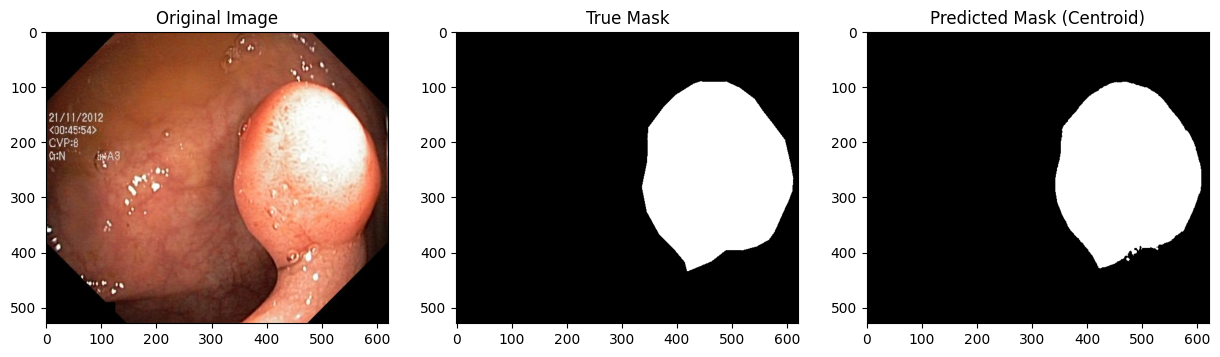

In [ ]:

image_path = val_images[3]
mask_path = val_masks[3]


true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
true_mask = (true_mask > 127).astype(np.uint8)


pred_mask = generate_predictions(image_path,mask_path)


visualize_results(image_path, pred_mask, true_mask)
